In [2]:
import numpy as np
import cv2 as cv
from pycocotools.coco import COCO
from sklearn.neighbors import KNeighborsClassifier
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import albumentations as A
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define transformation for resizing and normalizing
resize_transform = A.Compose([
    A.Resize(512, 512),  # Resize images to a consistent size
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

class FeatureBasedSeaTurtleDataset(Dataset):
    def __init__(self, image_ids, transform=None):
        self.coco = COCO("./turtles-data/data/updated_annotations.json")
        self.image_ids = image_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image_data = self.coco.loadImgs([image_id])[0]
        image_path = os.path.join("./turtles-data/data", image_data["file_name"])
        
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        mask = self._getmask(image_id, image)

        # Resize image and mask
        if self.transform is not None:
            augmented = self.transform(image=image)
            image = augmented["image"]
            mask = cv.resize(mask, (512, 512), interpolation=cv.INTER_NEAREST)

        # Convert image to HSV
        hsv_image = cv.cvtColor(image, cv.COLOR_RGB2HSV)

        # Prepare feature vectors: [R, G, B, H, S, V, x, y]
        h, w = image.shape[:2]
        coords = np.array([(x, y) for y in range(h) for x in range(w)])
        rgb_values = image.reshape(-1, 3)
        hsv_values = hsv_image.reshape(-1, 3)
        features = np.concatenate([rgb_values, hsv_values, coords], axis=1)

        # Flatten the mask
        labels = mask.flatten()

        return features, labels

    def _getmask(self, image_id, image):
        categories = {"turtle": 1, "flipper": 2, "head": 3}
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        for category_name, category_id in categories.items():
            ann_ids = self.coco.getAnnIds(imgIds=image_id, catIds=category_id, iscrowd=None)
            annotations = self.coco.loadAnns(ann_ids)

            temp_mask = np.zeros_like(mask)
            for ann in annotations:
                temp_mask += self.coco.annToMask(ann)

            if category_name == "turtle":
                mask[temp_mask > 0] = 1
            elif category_name == "flipper":
                mask[temp_mask > 0] = 2
            elif category_name == "head":
                mask[temp_mask > 0] = 3

        return mask

c:\Users\61402\anaconda3\envs\cv\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Load metadata and map image IDs
metadata_path = "./turtles-data/data/metadata_splits.csv"
metadata = pd.read_csv(metadata_path)
coco = FeatureBasedSeaTurtleDataset([]).coco
image_ids = coco.getImgIds()

img_to_filename = {img_id: coco.loadImgs(img_id)[0]["file_name"] for img_id in image_ids}
file_to_img = {v: k for k, v in img_to_filename.items()}

train_img_ids = [file_to_img[filename] for filename in metadata[metadata["split_open"] == "train"]["file_name"] if filename in file_to_img]
test_img_ids = [file_to_img[filename] for filename in metadata[metadata["split_open"] == "test"]["file_name"] if filename in file_to_img]

train_dataset = Subset(FeatureBasedSeaTurtleDataset(train_img_ids, transform=resize_transform), range(200))
test_dataset = Subset(FeatureBasedSeaTurtleDataset(test_img_ids, transform=resize_transform), range(100))

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

X_train, y_train = [], []

print("Processing training data...")
for features, labels in train_loader:
    X_train.extend(features.numpy())
    y_train.extend(labels.numpy())

X_train = np.vstack(X_train)
y_train = np.concatenate(y_train)

# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)


loading annotations into memory...
Done (t=17.85s)
creating index...
index created!
loading annotations into memory...
Done (t=16.82s)
creating index...
index created!
loading annotations into memory...
Done (t=28.57s)
creating index...
index created!
Processing training data...


KNeighborsClassifier(n_neighbors=3)

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_segmentation(test_loader, knn_model):
    y_true, y_pred = [], []

    print("Evaluating segmentation...")

    for features, labels in test_loader:
        # Flatten features and labels
        features = features.numpy().reshape(-1, features.shape[-1])
        labels = labels.numpy().flatten()

        # Predict the labels for each pixel
        pred_labels = knn_model.predict(features)

        # Append to overall lists
        y_true.extend(labels)
        y_pred.extend(pred_labels)

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=["background", "turtle", "flipper", "head"])
    print("Classification Report:")
    print(report)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    return report, cm

# Call the evaluation function
report, cm = evaluate_segmentation(test_loader, knn)


Evaluating segmentation...
Classification Report:
              precision    recall  f1-score   support

  background       0.94      0.85      0.90  22489914
      turtle       0.33      0.46      0.39   2343715
     flipper       0.12      0.23      0.16    867495
        head       0.07      0.13      0.09    513276

    accuracy                           0.78  26214400
   macro avg       0.37      0.42      0.38  26214400
weighted avg       0.84      0.78      0.81  26214400

Confusion Matrix:
[[19210803  1639306  1145604   494201]
 [  698309  1085195   305606   254605]
 [  400964   209111   201402    56018]
 [   87882   325106    35418    64870]]


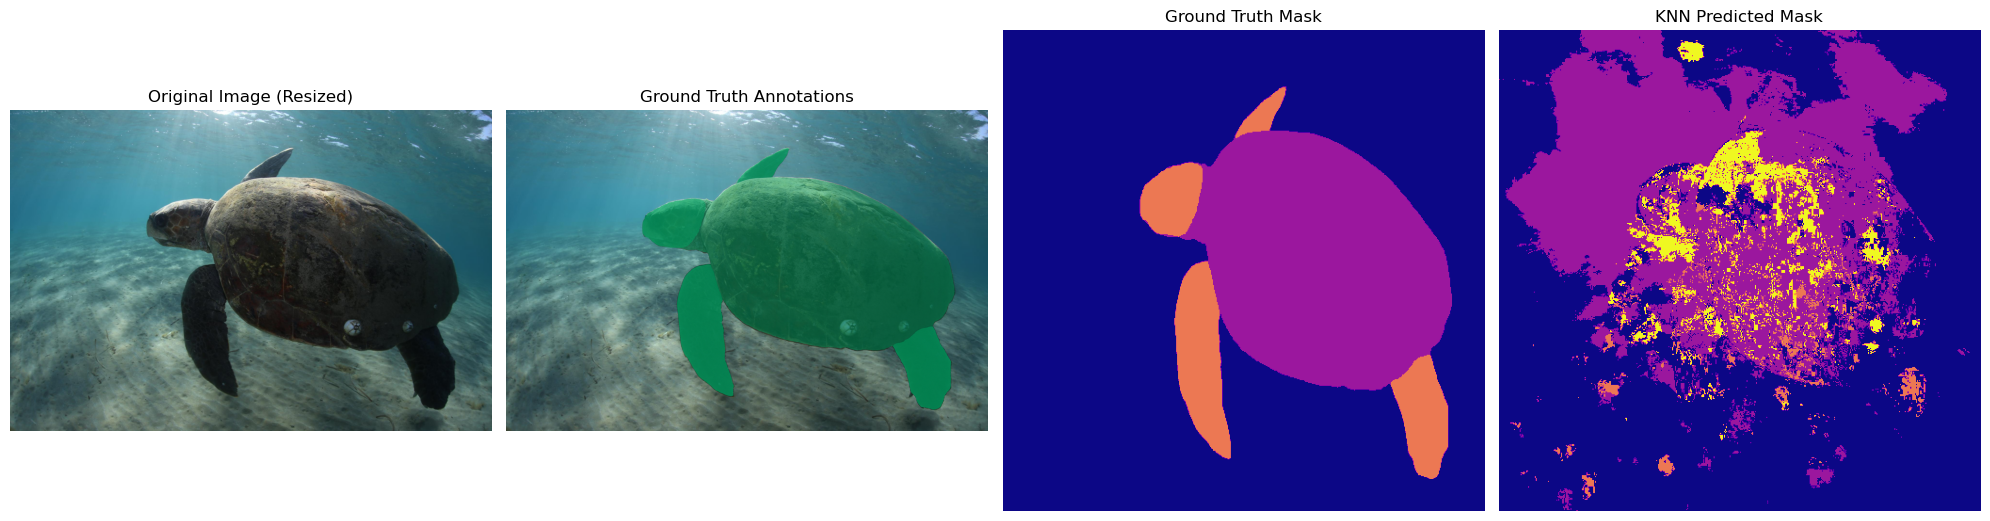

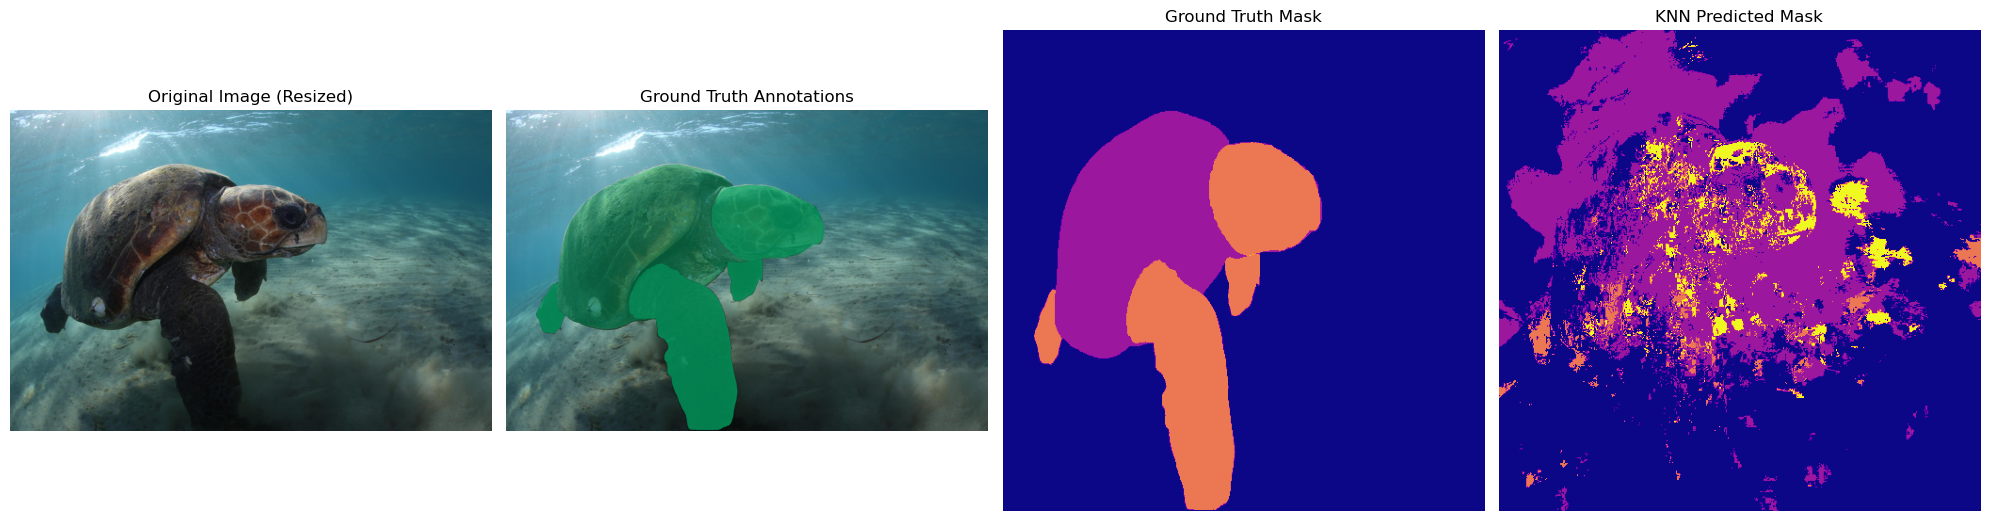

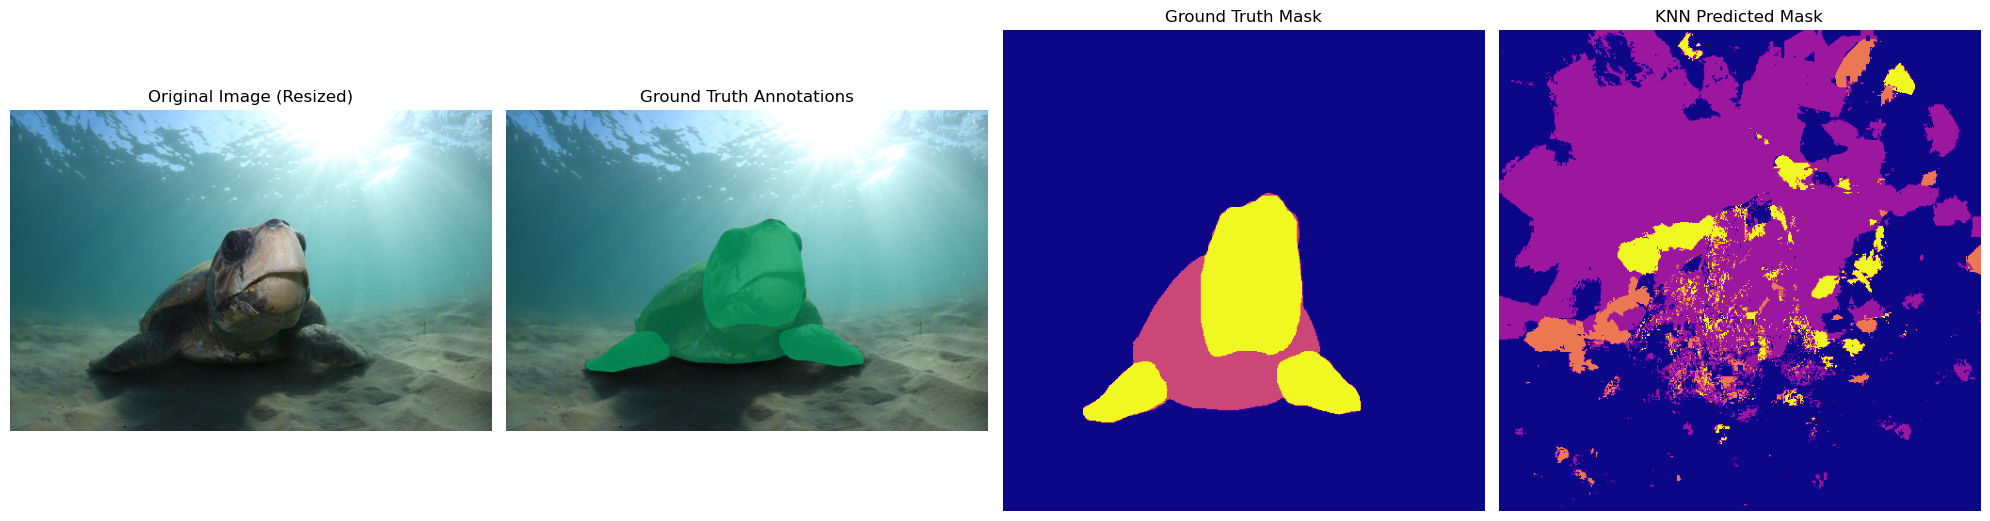

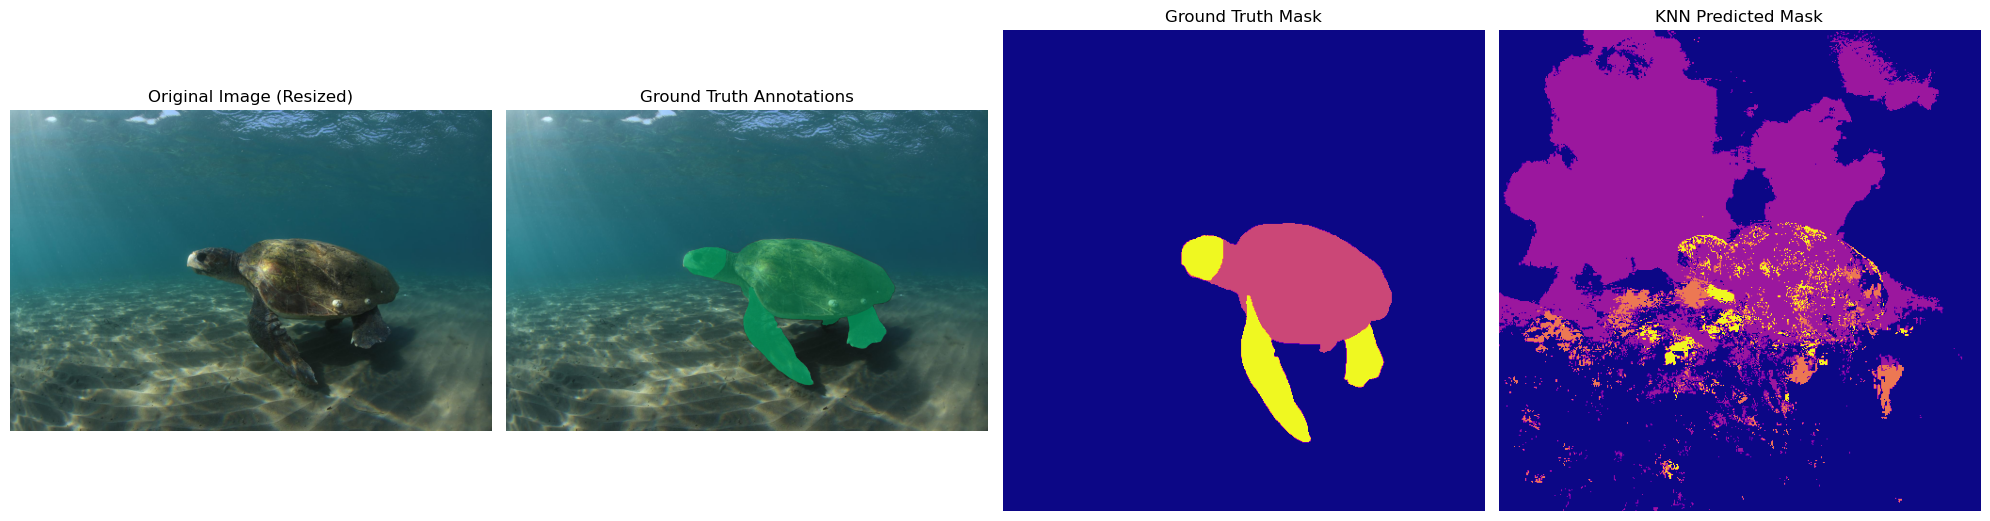

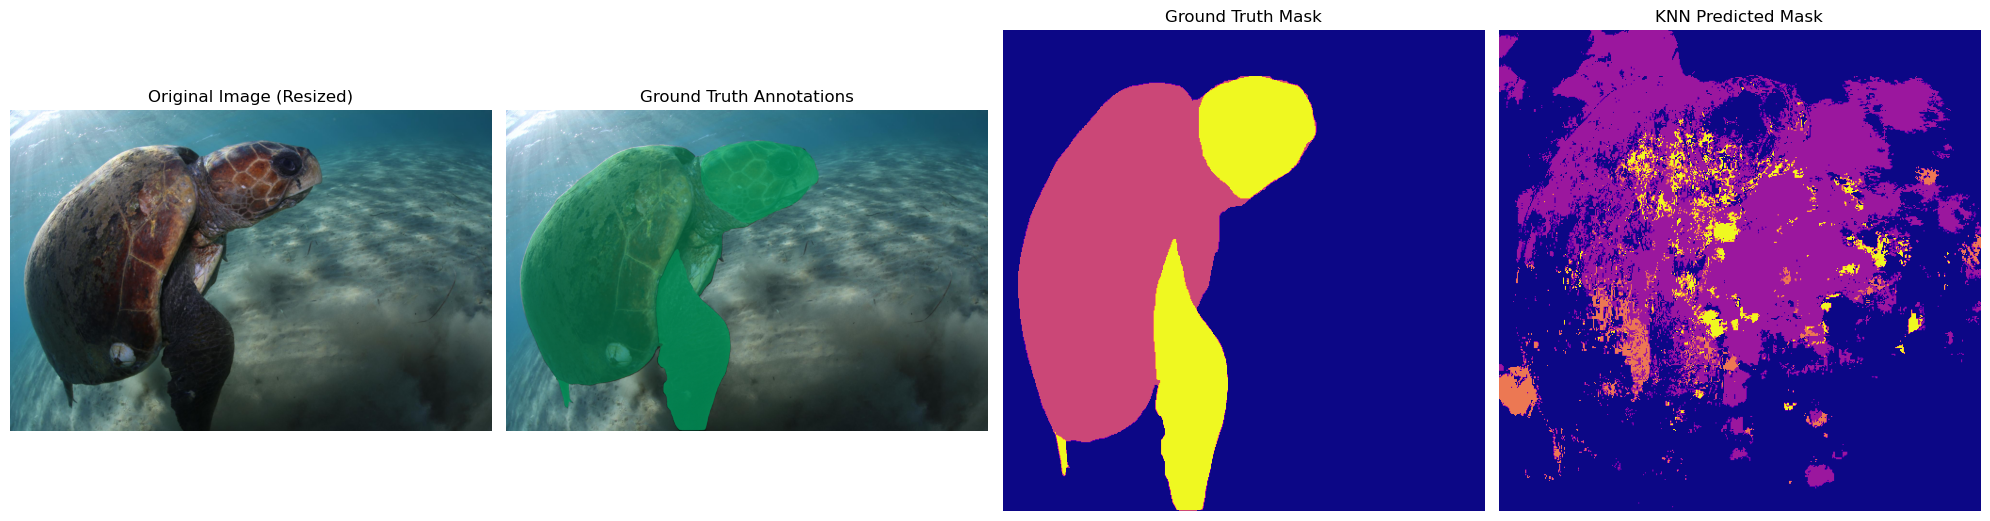

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image


def display_images_with_segmentation2(image_ids, knn_model):
    for image_id in image_ids:
        try:
            # Load image metadata
            img_info = coco.loadImgs(image_id)[0]
            image_path = f"turtles-data/data/{img_info['file_name']}"
            image = np.array(Image.open(image_path))

            # Resize the image to (128, 128)
            image_resized = cv.resize(image, (512, 512), interpolation=cv.INTER_NEAREST)

            # Ground Truth Annotations
            cat_ids = coco.getCatIds()
            ann_ids = coco.getAnnIds(imgIds=img_info["id"], catIds=cat_ids, iscrowd=None)
            anns = coco.loadAnns(ann_ids)

            # Create Ground Truth Mask
            mask = np.zeros((img_info["height"], img_info["width"]), dtype=np.uint8)
            for ann in anns:
                mask += coco.annToMask(ann)
            mask_resized = cv.resize(mask, (512, 512), interpolation=cv.INTER_NEAREST)

            # Prepare features for KNN prediction (RGB, HSV, and spatial coordinates)
            hsv_image = cv.cvtColor(image_resized, cv.COLOR_RGB2HSV)
            coords = np.array([(x, y) for y in range(512) for x in range(512)])
            rgb_values = image_resized.reshape(-1, 3)
            hsv_values = hsv_image.reshape(-1, 3)
            features = np.concatenate([rgb_values, hsv_values, coords], axis=1)  # Shape: (16384, 8)

            # KNN Predicted Mask
            pred_mask_flat = knn_model.predict(features)
            pred_mask = pred_mask_flat.reshape((512, 512))

            # Display the results
            plt.figure(figsize=(20, 10))

            # Panel 1: Original Image
            plt.subplot(1, 4, 1)
            plt.imshow(image)
            plt.axis("off")
            plt.title("Original Image (Resized)")

            # Panel 2: Ground Truth Annotations
            plt.subplot(1, 4, 2)
            plt.imshow(image)
            coco.showAnns(anns)
            plt.axis("off")
            plt.title("Ground Truth Annotations")

            # Panel 3: Ground Truth Mask
            plt.subplot(1, 4, 3)
            plt.imshow(mask_resized, cmap="plasma")
            plt.axis("off")
            plt.title("Ground Truth Mask")

            # Panel 4: KNN Predicted Mask
            plt.subplot(1, 4, 4)
            plt.imshow(pred_mask, cmap="plasma")
            plt.axis("off")
            plt.title("KNN Predicted Mask")

            plt.tight_layout()
            plt.show()

        except FileNotFoundError:
            print(f"[DEBUG]: This image was already deleted: {image_id}. It has been removed from the dataset.")
        except Exception as e:
            print(f"[DEBUG]: An error occurred while processing image ID {image_id}: {e}")

# Display segmentation results for a few test images
sample_image_ids = test_img_ids[:5]  # Use a small sample for quick visualization
display_images_with_segmentation2(sample_image_ids, knn)
